In [1]:
# Data handling
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Optimization
import swifter
from scipy.sparse import csr_matrix

# ML
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.base import clone

# Export Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, TextVectorization
from scikeras.wrappers import KerasClassifier

/Users/till/.pyenv/versions/3.10.6/envs/fake-data-detector/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
# Data Loading

def load_data(filepath):
    """Loads data from a CSV file."""
    data = pd.read_csv(filepath, encoding="utf-8")
    df = data.copy()
    df = df.drop(columns=["prompt_id", "text_length", "word_count"])
    df["source"] = df["source"].apply(lambda x: 1 if x != "Human" else 0)
    return df

In [3]:
# Text Cleaning

class TextCleaner(BaseEstimator, TransformerMixin):
    def text_cleaning(self, text):
        if not isinstance(text, str):  # ✅ Convert non-string inputs
            text = str(text)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove extra spaces
        text = ' '.join(text.split())
        return text.strip()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Apply cleaning to text column."""
        if isinstance(X, pd.DataFrame):
            return X.assign(text=X["text"].apply(self.text_cleaning))  # Clean DataFrame column
        return X.apply(self.text_cleaning)  # Clean Series

In [4]:
# TF-IDF Vectorization

class TFIDFVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, max_features=10000, ngram_range=(1,2), stop_words="english"):
        """
        Custom TF-IDF vectorizer with optimizations.
        - max_features: Limits vocabulary size to the most important words.
        - ngram_range: (1,1) for unigrams, (1,2) for bigrams, etc.
        """
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.stop_words = stop_words
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words=stop_words)


    def fit(self, X, y=None):
        """Fit the vectorizer to the text data."""
        if isinstance(X, pd.DataFrame) and "text" in X.columns:
            X = X["text"]
        self.vectorizer.fit(X)
        return self


    def transform(self, X):
        """Transforms text data into TF-IDF feature vectors."""
        if isinstance(X, pd.DataFrame) and "text" in X.columns:
            X = X["text"]
        vec_result = self.vectorizer.transform(X)
        return vec_result.toarray()  # Ensures Output is Numeric

In [5]:
# Model Evaluation

class EvaluationPipeline:
    def __init__(self, model):
        """Initialize with a trained model."""
        self.model = model
        self.train_acc_history = []

    def track_accuracy(self, X_train, y_train):
        """Track training and validation accuracy over epochs."""
        # Ensure accuracy history is cleared before tracking
        self.train_acc_history.clear()

        classifier = self.model.named_steps.get("classifier")
        if hasattr(classifier, "model_") and hasattr(classifier.model_, "history"):
            self.train_acc_history = classifier.model_.history.history.get("accuracy", [])

        print(f"\nTraining Accuracy: {self.train_acc_history[-1]:.4f}" if self.train_acc_history else
          "\nWarning: Accuracy history is empty. Ensure 'track_accuracy' is called before `evaluate`.")


    def evaluate(self, X_test, y_test):
        """Evaluate the trained model on test data."""
        y_pred_proba = self.model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probability to class labels

        results = {
            "loss": log_loss(y_test, y_pred_proba),
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_pred_proba)}

        # Print performance
        print("Model Performance on Test Set:")
        print(f"Loss: {results['loss']:.4f}")
        print(f"Accuracy: {results['accuracy']:.4f}")
        print(f"Precision: {results['precision']:.4f}")
        print(f"Recall: {results['recall']:.4f}")
        print(f"ROC-AUC: {results['roc_auc']:.4f}")

        # Convergence Plot
        if self.train_acc_history:
            plt.figure(figsize=(5, 4))
            plt.plot(range(1, len(self.train_acc_history) +1), self.train_acc_history, label="Train Accuracy")
            plt.xticks(range(1, len(self.train_acc_history) +1))  # Ensure correct X-axis scaling
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.title("Training Accuracy Over Epochs")
            plt.legend()
            plt.grid()
            plt.show()
        else:
            print("\nWarning: Accuracy history is empty. Ensure 'track_accuracy' is called before `evaluate`.")

        # Confusion Matrix Plot
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
        plt.xlabel("Predicted Label")
        plt.ylabel("Actual Label")
        plt.title("Confusion Matrix")
        plt.show()

In [6]:
# Keras model

def build_keras_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),  # Input dim = tfidf max feature
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification (AI vs. Human)
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_dim = 10000

# Wrap the model in KerasClassifier (for compatibility with scikit-learn pipeline)
keras_wrapper = KerasClassifier(
    model=build_keras_model,
    input_dim=input_dim,
    epochs=10, batch_size=32, verbose=1)

# Pipelines

In [7]:
final_pipeline = Pipeline([
    ("text_cleaning", TextCleaner()),
    ("tfidf", TFIDFVectorizer(max_features=10000, stop_words="english")),
    ("classifier", keras_wrapper)
     ])

evaluator = EvaluationPipeline(model=final_pipeline)

In [8]:
# Predict Text (UI)
class TextClassificationModel:
    def __init__(self, pipeline):
        """Wrap the pre-trained pipeline."""
        self.pipeline = pipeline

    def predict(self, input_text: str):
        """Predict whether the input text is AI or Human."""
        # Convert input into DataFrame (expected by pipeline)
        input_df = pd.DataFrame({"text": [input_text]})

        try:
            # Apply transformation separately if needed
            input_df = self.pipeline[:-1].transform(input_df)  # Process text excluding classifier

            # Make prediction using the classifier
            y_pred_proba = self.pipeline.steps[-1][1].predict_proba(input_df)

            # Ensure y_pred_proba is a 2D array (even for a single sample)
            if y_pred_proba.ndim == 1:
                y_pred_proba = y_pred_proba.reshape(1, -1)

            # Extract probability for AI class (assumed to be at index 1)
            ai_probability = y_pred_proba[0, 1]  # First row, second column

            # Determine prediction and format probability
            prediction = "AI" if ai_probability > 0.5 else "Human"
            probability = f"{ai_probability * 100:.2f}%"

            return {"Prediction": prediction, "AI Probability": probability}

        except Exception as e:
            # Handle potential errors (e.g., pipeline not fitted, invalid input)
            return {"Error": str(e)}

# Create model instance
model = TextClassificationModel(final_pipeline)

# Test Use

In [9]:
df = load_data("../../data/10k_sampled_dataset.csv")

df.head()

,text,source
0,"In 1466, perhaps 40,000 people died of the pla...",1
1,Amazon's yet-unnamed Lord of the Rings origina...,1
2,@Holt \n***Hi. I've just rewritten the essay....,0
3,Pleasantly surprised! Had a few options for ve...,1
4,Shakespeare’s Othello: A Tragic Hero Research ...,0


In [10]:
df["source"].value_counts(normalize=True)

source
0    0.5577
1    0.4423
Name: proportion, dtype: float64

In [11]:
# Train and evaluate

X = df["text"]  # Raw text input
y = df["source"]  # Labels (0=Human, 1=AI)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7360 - loss: 0.4821
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9585 - loss: 0.1138
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9898 - loss: 0.0387
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9962 - loss: 0.0151
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0047
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9994 - loss: 0.0024
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 9.7425e-04
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9994 - loss: 0.0013
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.6267e-04
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.8770e-04

Training Accuracy: 1.0000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
Model Performance on Test Set:
Loss: 3.6765
Accuracy: 0.898

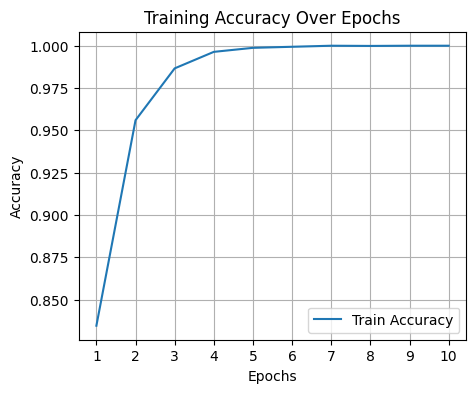

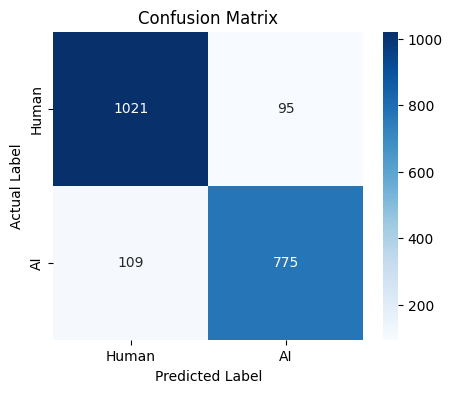

In [12]:
# Train Model
final_pipeline.fit(X_train, y_train)

# Track Accuracy History (Ensure This is Called Before Evaluation)
evaluator.track_accuracy(X_train, y_train)

# Evaluate Model
results = evaluator.evaluate(X_test, y_test)
results

# Save Model

In [13]:
# Save model
keras_model = final_pipeline.named_steps["classifier"].model_
keras_model.save("../export/final_keras_model01.keras")
print("Model has been saved..")

# Save Pipeline
joblib.dump(final_pipeline, "../export/final_pipeline01.pkl")
print("Pipeline has been saved..")

Model has been saved..
Pipeline has been saved..


# Test Use

In [14]:
test01 = "Melbourne, Australia, is renowned for its vibrant and sophisticated coffee culture, often considered one of the best in the world. The city’s laneways are dotted with cozy cafes, each offering meticulously crafted brews that reflect a deep passion for quality and artistry. From flat whites to single-origin pour-overs, Melbourne’s baristas are skilled artisans, dedicated to perfecting every cup. The coffee scene here is more than just a drink—it’s a lifestyle, a social ritual, and a celebration of community. Locals take pride in their coffee knowledge, favoring independent roasters and ethically sourced beans. Whether it’s a hidden gem in Degraves Street or a trendy spot in Fitzroy, Melbourne’s coffee culture is an immersive experience, blending innovation with tradition, and creating a haven for coffee lovers from around the globe."

y_pred = model.predict(test01)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


{'Prediction': 'AI', 'AI Probability': '94.68%'}

In [15]:
test02 = "Cats are known to be bringing luck to the house, although there's been misconception that black cats brings bad luck. Can you distinguish between people who own cats and who owns dogs? Many people believe that cat owners are more introverted and dog owners are the exact opposite."

y_pred = model.predict(test02)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


{'Prediction': 'AI', 'AI Probability': '96.25%'}

In [16]:
test03 = "Bali is extremely hot today. I can't wait for winter."

y_pred = model.predict(test03)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


{'Prediction': 'AI', 'AI Probability': '99.94%'}